In [3]:
import numpy as np
from math import log

# Constants
R = 8.314
Omega = 2.0e4
T = 1000.0   # Temperature (K)

# Free energy and derivatives
def G_mix(x, T):
    return (
        Omega * x * (1.0 - x)
        + R*T*(x*log(x) + (1.0 - x)*log(1.0 - x))
    )

def dGdx(x, T):
    return (
        Omega*(1.0 - 2.0*x)
        + R*T*(log(x) - log(1.0 - x))
    )

def d2Gdx2(x, T):
    return (
        -2.0*Omega +
        R*T*(1.0/x + 1.0/(1.0 - x))
    )

# -------------------------
# Newton iteration function
# -------------------------
def newton_solve(x0, T, tol=1e-12, max_iter=100):
    x = x0
    history = []

    for n in range(max_iter):
        f = dGdx(x, T)
        fp = d2Gdx2(x, T)
        history.append((n, x, f, fp))

        if abs(f) < tol:
            break

        x = x - f/fp
    
    return x, history

# -------------------------
# Solve binodal equation
# -------------------------

# Start left side near 0.2
x_left_guess = 0.2
x1, hist1 = newton_solve(x_left_guess, T)

# Symmetric right side (regular-solution model is symmetric)
x2 = 1.0 - x1

# -------------------------
# Output: Step-by-step table
# -------------------------

print("\nNEWTON ITERATION TABLE (left binodal root)")
print("iter      x                dGdx(x)              d2Gdx2(x)")
for it, xv, fv, fpv in hist1:
    print(f"{it:3d}   {xv:14.10f}   {fv:14.6e}   {fpv:14.6e}")

print("\nBinodal compositions at T = 1000 K:")
print(f"x1 = {x1:.12f}")
print(f"x2 = {x2:.12f}")

# -------------------------
# Verification
# -------------------------
print("\nVerification:")
print(f"G(x1) = {G_mix(x1,T):.6f} J/mol")
print(f"G(x2) = {G_mix(x2,T):.6f} J/mol")
print(f"dGdx(x1) = {dGdx(x1,T):.3e}")
print(f"dGdx(x2) = {dGdx(x2,T):.3e}")



NEWTON ITERATION TABLE (left binodal root)
iter      x                dGdx(x)              d2Gdx2(x)
  0     0.2000000000     4.743487e+02     1.196250e+04
  1     0.1603470277    -1.789410e+02     2.175175e+04
  2     0.1685735369    -1.017975e+01     1.931940e+04
  3     0.1691004551    -3.886034e-02     1.917206e+04
  4     0.1691024820    -5.725196e-07     1.917150e+04
  5     0.1691024820     0.000000e+00     1.917150e+04

Binodal compositions at T = 1000 K:
x1 = 0.169102482040
x2 = 0.830897517960

Verification:
G(x1) = -968.245663 J/mol
G(x2) = -968.245663 J/mol
dGdx(x1) = 0.000e+00
dGdx(x2) = 0.000e+00


/tmp/ipykernel_14640/60054688.py:10: RuntimeWarning: invalid value encountered in log
  return Omega*(1 - 2*x) + R*T*(np.log(x) - np.log(1 - x))


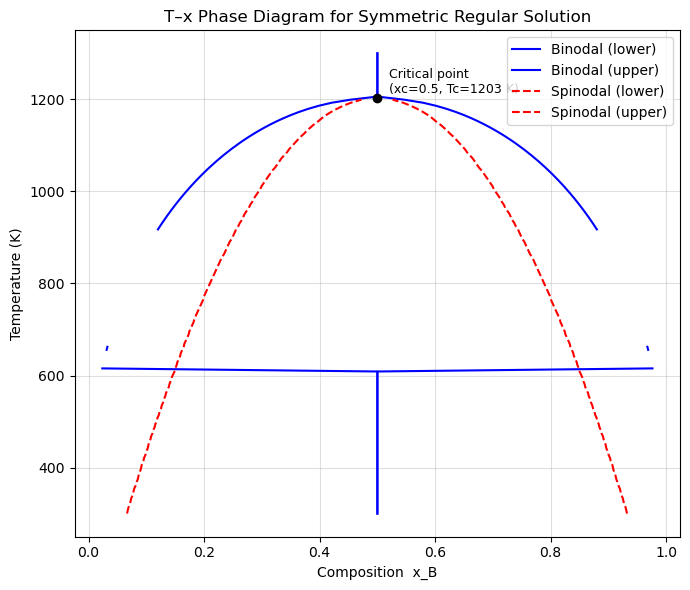

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
R = 8.314
Omega = 2.0e4

# Free-energy derivatives
def dGdx(x, T):
    return Omega*(1 - 2*x) + R*T*(np.log(x) - np.log(1 - x))

def d2Gdx2(x, T):
    return -2*Omega + R*T*(1/x + 1/(1 - x))

# Simple Newton root solver
def newton(f, fp, x0, T, tol=1e-10, maxit=50):
    x = x0
    for _ in range(maxit):
        fx = f(x, T)
        fpx = fp(x, T)
        x_new = x - fx/fpx
        if abs(x_new - x) < tol:
            return x_new
        x = x_new
    return np.nan

# Temperature range
T_vals = np.linspace(300, 1300, 150)

binodal_lower = []
binodal_upper = []
spinodal_lower = []
spinodal_upper = []

for T in T_vals:
    # Spinodal: solve d²G/dx² = 0 by scanning for sign changes
    xs = np.linspace(0.01, 0.99, 800)
    curvature = d2Gdx2(xs, T)
    idx = np.where(np.diff(np.sign(curvature)))[0]

    if len(idx) >= 2:
        spinodal_lower.append(xs[idx[0]])
        spinodal_upper.append(xs[idx[-1]])
    else:
        spinodal_lower.append(np.nan)
        spinodal_upper.append(np.nan)

    # Binodal: solve common tangent via symmetry → dG/dx(x1) = 0 with x2 = 1 - x1
    try:
        x1 = newton(dGdx, d2Gdx2, 0.2, T)
        x2 = 1 - x1
        binodal_lower.append(x1)
        binodal_upper.append(x2)
    except:
        binodal_lower.append(np.nan)
        binodal_upper.append(np.nan)

# Compute critical point
Tc = Omega / (2 * R)
xc = 0.5

# ----- Plot -----
plt.figure(figsize=(7, 6))

# Binodal
plt.plot(binodal_lower, T_vals, label="Binodal (lower)", color="blue")
plt.plot(binodal_upper, T_vals, label="Binodal (upper)", color="blue")

# Spinodal
plt.plot(spinodal_lower, T_vals, "--", label="Spinodal (lower)", color="red")
plt.plot(spinodal_upper, T_vals, "--", label="Spinodal (upper)", color="red")

# Critical point
plt.scatter([xc], [Tc], color="black", zorder=5)
plt.text(xc + 0.02, Tc + 10, f"Critical point\n(xc=0.5, Tc={Tc:.0f} K)", fontsize=9)

plt.xlabel("Composition  x_B")
plt.ylabel("Temperature (K)")
plt.title("T–x Phase Diagram for Symmetric Regular Solution")
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()
